In [340]:
from datetime import datetime
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
BASE_DATA_PATH = os.path.join("out_tfg_v3")
OUTPUT_FOLDER = os.path.join(os.path.expanduser("~"), "tfg_info", "figuras", "benchmarks")
TIMES_IN_MS = False

def get_dataset_file(cloud_name, timestamp = "latest", data_path = BASE_DATA_PATH):
    # Get all CSV files in the folder
    csv_folder = os.path.join(data_path, cloud_name)
    csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
    df = None
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {csv_folder}")
    if timestamp == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),
            "%Y-%m-%d-%H:%M:%S"
        ))
        print(f"Loading latest file: {file}")
        df = pd.read_csv(file)
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            file_timestamp = filename.split('-')[1:]  # Split to get timestamp part
            file_timestamp = '-'.join(file_timestamp).replace('.csv', '')  # Rebuild timestamp string
            if timestamp == file_timestamp:
                print(f"Loading file: {file}")
                df = pd.read_csv(file)
        if df is None:
               FileNotFoundError(f"File with date '{timestamp}' not found in folder: {csv_folder}")
    # Convert times to milliseconds
    if TIMES_IN_MS:
        df['mean'] = df['mean'] * 1000
        df['stdev'] = df['stdev'] * 1000
        df['warmup_time'] = df['warmup_time'] * 1000
    return df

def read_multiple_datasets(clouds_datasets, data_path = BASE_DATA_PATH):
    dfs = {}
    for cloud, dataset in clouds_datasets.items():
        dfs[cloud] = get_dataset_file(cloud, "latest", data_path)
    return dfs

def output_fig(fig, filename):
    fig.savefig(os.path.join(OUTPUT_FOLDER, filename + ".pdf"), dpi=300, bbox_inches='tight')
    plt.close(fig)

In [341]:
import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    #'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,  
    
    'axes.grid': True,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 100, 
    #'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',   # Edge color of the figure
})


In [342]:
def add_octree_types_legend(legend_handles, legend_labels, legend_title, fig, pos = (0.9, 0.97)):
    legend = fig.legend(
        legend_handles,
        legend_labels,
        title=legend_title,
        loc="upper right",
        bbox_to_anchor=pos,
        ncol=len(legend_handles),
        columnspacing=0.8,     # Reduce horizontal space between columns
        handletextpad=0.4,     # Reduce space between handle and text
        borderpad=0.5,         # Padding inside the legend box
        labelspacing=0.3,       # Reduce vertical space between labels
    )

In [343]:
NEIGHBORS_PTR = "neighborsPtr"
NEIGHBORS = "neighbors"
NEIGHBORS_PRUNE = "neighborsPrune"
NEIGHBORS_STRUCT = "neighborsStruct"
NEIGHBORS_APPROX_LOWER = "neighborsApproxLower"
NEIGHBORS_APPROX_UPPER = "neighborsApproxUpper"
MORTON_ENCODER = "MortonEncoder3D"
HILBERT_ENCODER = "HilbertEncoder3D"
NO_ENCODER = "NoEncoding"
LINEAR_OCTREE = "LinearOctree"
POINTER_OCTREE = "Octree"
UNIBN_OCTREE = "unibnOctree"
PCL_KDTREE = "PCLKdTree"
NEIGHBORS_PCLKD = "neighborsPCLKD"
NEIGHBORS_UNIBN = "neighborsUnibn"

In [344]:
# This dicts store information about the type parameters and possible combinations used in each visualization, 
# along with the palette of colors
TYPES_INFO_OCTREE_ENCODER = {
    "type_parameters":  ['octree', 'encoder'],
    "available_types": pd.DataFrame({
        'octree': [LINEAR_OCTREE, LINEAR_OCTREE, POINTER_OCTREE, POINTER_OCTREE, POINTER_OCTREE],
        'encoder': [HILBERT_ENCODER, MORTON_ENCODER, HILBERT_ENCODER, MORTON_ENCODER, NO_ENCODER]
    }),

    "palette": {
        (LINEAR_OCTREE, HILBERT_ENCODER): '#1984c5',
        (LINEAR_OCTREE, MORTON_ENCODER): '#63bff0',
        (POINTER_OCTREE, HILBERT_ENCODER): '#c23728',
        (POINTER_OCTREE, MORTON_ENCODER): '#de6e56',
        (POINTER_OCTREE, NO_ENCODER): '#e1a692'
    },
    "display_name" : {
        (LINEAR_OCTREE, HILBERT_ENCODER): r'\texttt{loct\_hilb}',
        (LINEAR_OCTREE, MORTON_ENCODER): r'\texttt{loct\_mort}',
        (POINTER_OCTREE, HILBERT_ENCODER): r'\texttt{poct\_hilb}',
        (POINTER_OCTREE, MORTON_ENCODER): r'\texttt{poct\_mort}',
        (POINTER_OCTREE, NO_ENCODER): r'\texttt{poct\_unsorted}'
    }
}

palette_ops = sns.color_palette("viridis", n_colors=4)
palette_structs = sns.dark_palette(palette_ops[3], n_colors=6, input="rgb")
sns.hls_palette()
TYPES_INFO_OPERATIONS = {
    "type_parameters":  ['octree', 'operation'],
    "available_types": pd.DataFrame({
        'octree': [POINTER_OCTREE, LINEAR_OCTREE, LINEAR_OCTREE, LINEAR_OCTREE],
        'operation': [NEIGHBORS_PTR, NEIGHBORS, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT]
    }),

    "palette": {
        (POINTER_OCTREE, NEIGHBORS_PTR): palette_ops[0],
        (LINEAR_OCTREE, NEIGHBORS): palette_ops[1],
        (LINEAR_OCTREE, NEIGHBORS_PRUNE): palette_ops[2],
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): palette_ops[3],
    },
    "display_name" : {
        (POINTER_OCTREE, NEIGHBORS_PTR): r'\textit{neighborsPtr}',
        (LINEAR_OCTREE, NEIGHBORS): r'\textit{neighbors}',
        (LINEAR_OCTREE, NEIGHBORS_PRUNE): r'\textit{neighborsPrune}',
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): r'\textit{neighborsStruct}',
    }
}

TYPES_INFO_STRUCTURES = {
    "type_parameters":  ['octree', 'operation'],
    "available_types": pd.DataFrame({
        'octree': [LINEAR_OCTREE, UNIBN_OCTREE, PCL_KDTREE],
        'operation': [NEIGHBORS_STRUCT, NEIGHBORS_UNIBN, NEIGHBORS_PCLKD]
    }),
    "markertype": {
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): 'o',  # circle
        (UNIBN_OCTREE, NEIGHBORS_UNIBN): 'x',    # x marker
        (PCL_KDTREE, NEIGHBORS_PCLKD): '^'       # triangle up
    },
    "palette": {
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): palette_structs[5],
        (UNIBN_OCTREE, NEIGHBORS_UNIBN): palette_structs[3],
        (PCL_KDTREE, NEIGHBORS_PCLKD): palette_structs[1]
    },
    "display_name" : {
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): r'\textit{neighborsStruct}',
        (UNIBN_OCTREE, NEIGHBORS_UNIBN): r'\textit{unibnOctree}',
        (PCL_KDTREE, NEIGHBORS_PCLKD): r'\textit{PCL KD-tree}'
    }
}

In [345]:
from matplotlib.colors import rgb2hex
palette_ops = sns.color_palette("viridis", n_colors=4)
hex_colors = [rgb2hex(color) for color in palette_ops]
print(hex_colors)

['#414487', '#2a788e', '#22a884', '#7ad151']


In [346]:
DATA_SUBSET = os.path.join(BASE_DATA_PATH, "subset")
DATA_FULL = os.path.join(BASE_DATA_PATH, "full")
DATA_PARALLEL_SUBSET = os.path.join(BASE_DATA_PATH, "parallel_subset")
DATA_PARALLEL_FULL = os.path.join(BASE_DATA_PATH, "parallel_full")
DATA_APPROX_SUBSET = os.path.join(BASE_DATA_PATH, "approx_subset")
DATA_APPROX_FULL = os.path.join(BASE_DATA_PATH, "approx_full")

In [347]:
# Multiple datasets
CLOUDS_DATASETS = {
                    "Lille_0": "Paris_Lille", 
                    "Paris_Luxembourg_6": "Paris_Lille",
                    "5080_54400": "DALES"
                }
RADII = {0.5, 1.0, 2.0, 3.0}
CLOUDS_DATASETS_HIGH_DENSITY = {
                    "bildstein_station1_xyz_intensity_rgb": "Semantic3D",
                    "sg27_station8_intensity_rgb": "Semantic3D",
                    "Speulderbos_2017_TLS": "Speulderbos"
                }
RADII_HIGH_DENSITY = {0.01, 0.05, 0.1}
ALL_CLOUDS = CLOUDS_DATASETS.copy()
ALL_CLOUDS.update(CLOUDS_DATASETS_HIGH_DENSITY)

In [348]:
def octree_runtime_comparison(cloud, data_path, operations , legend_title = r"Combinación \textit{Octree} y SFC", 
                                show_warmup_time=False, types_info=TYPES_INFO_OCTREE_ENCODER, cols = 1, figsz = (7,10), legend_pos=(0.9, 1.0), encoder = "all", kernels="all", show_legend = True):
    df = get_dataset_file(cloud, "latest", data_path)
    # Filter the dataset for the specified operation
    df = df[df['operation'].isin(operations)]
    # Get unique radii and kernels
    radii = sorted(df['radius'].unique())
    if kernels != "all":
        if isinstance(kernels, str):
            kernels = [kernels]
        df = df[df["kernel"].isin(kernels)]
    
    kernels = df['kernel'].unique()
    if encoder != "all":
        df = df[df["encoder"] == encoder]

    print(df)
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(int(np.ceil(len(radii)/cols)), cols, figsize=figsz,
                              gridspec_kw={'hspace': 0.3}, squeeze = False)

    # Bar spacing parameters
    bar_width = 0.15
    group_width = bar_width * len(types_info["available_types"])
    group_gap = 0.2
    legend_handles, legend_labels = [], []
    curr_row, curr_col = 0, 0
    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[curr_row][curr_col]
        radius_data = df[df['radius'] == radius]
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = []
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'Kernel {kernel}\nSin datos')
                continue
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f"$\\mathcal{{N}}_{{{kernel}}}$\n$\\mu = {avg_total:.0f}$")
            # Finally, iterate through each of the octree implementations identified by the (octree, encoder, point_type) tuple
            for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
                # Extract parameters dynamically from the row
                key = tuple(params[col] for col in types_info["type_parameters"])
                octree_data = kernel_data[
                    (kernel_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]
                if octree_data.empty:
                    continue
                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                warmup_times = octree_data['warmup_time'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                
                # Main execution time bar
                bar = ax.bar(x_pos, means[0], bar_width,
                             color=types_info["palette"][key])
                
                # Warmup time bar (if enabled)
                if show_warmup_time:
                    ax.bar(x_pos, warmup_times[0], bar_width, 
                           color="none", 
                           edgecolor='black', alpha = 0.5,
                           zorder=-2)  # Ensure it's drawn on top
                
                ax.errorbar(x_pos, means[0], stdevs[0],
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
                formatted_label = types_info["display_name"][key]
                if radius_idx == 0 and formatted_label not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        alignment_x = 0 if curr_col == 0 else 0.85
        ax.text(alignment_x, 1.1, f'$r = {radius}$',
                transform=ax.transAxes,
                fontsize=16,
                va='top', ha='left')
       
        ax.set_ylabel(f"Tiempo total {'(ms)' if TIMES_IN_MS else '(s)'}")
        ax.tick_params(axis="x", which="both", length=0)
        curr_col += 1
        if curr_col == cols:
            curr_col = 0
            curr_row+=1
    if show_legend:
        add_octree_types_legend(legend_handles, legend_labels, legend_title, fig, pos = legend_pos)
    return fig

In [349]:
import scipy.stats as stats
def plot_avg_result_sizes_log(clouds_datasets, kernel, operations, data_path, types_info=TYPES_INFO_OCTREE_ENCODER, encoder = "all", 
                              legend_pos = (0.905, 0.98), show_legend = True, legend_title = r"Combinación \textit{Octree} y SFC", fsz=(8,7)):
    dfs = read_multiple_datasets(clouds_datasets, data_path)
    fig, ax = plt.subplots(figsize=fsz)
    legend_handles, legend_labels = [], []
    
    for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
        key = tuple(params[col] for col in types_info["type_parameters"])
        avg_sizes, runtimes = [], []
        for df_name, df in dfs.items():
            if kernel == "all":
                df = df[(df['operation'].isin(operations))]
            else:
                df = df[(df['kernel'] == kernel) & (df['operation'].isin(operations))]
            if encoder != "all":
                df = df[df["encoder"] == encoder]
            if df.empty:
                continue
            octree_data = df[
                (df[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
            ]
            if octree_data.empty:
                continue
            avg_sizes.extend(octree_data['avg_result_size'].tolist())
            runtimes.extend(octree_data['mean'].tolist())

        if avg_sizes and runtimes:
            scatter_kwargs = {'s': 20}
            if "palette" in types_info:
                scatter_kwargs['color'] = types_info["palette"][key]
            if "markertype" in types_info:
                scatter_kwargs['s'] = 35
                scatter_kwargs['marker'] = types_info["markertype"][key]

            scatter = ax.scatter(avg_sizes, runtimes, **scatter_kwargs)
            legend_handles.append(scatter)
            legend_labels.append(types_info["display_name"][key])
            # linear regression line
            # slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(avg_sizes), np.log(runtimes))
            # regression_line = np.exp(intercept + slope * np.log(np.array(avg_sizes)))
            # ax.plot(avg_sizes, regression_line, color=types_info["palette"][key], linestyle='dashed', linewidth=1)
    
    total_morton_runtimes = []
    total_hilbert_runtimes = []
    for df_name, df in dfs.items():
        if df.empty:
            continue
        morton_df = df[(df["encoder"] == MORTON_ENCODER)]
        hilbert_df = df[(df["encoder"] == HILBERT_ENCODER)]
        total_morton_runtimes.extend(morton_df["mean"].tolist())
        total_hilbert_runtimes.extend(hilbert_df["mean"].tolist())
    # Compute average reduction across all matched pairs
    avg_morton_runtime = np.mean(total_morton_runtimes)
    avg_hilbert_runtime = np.mean(total_hilbert_runtimes)

    print(f"Average Morton runtime:  {avg_morton_runtime:.4f}")
    print(f"Average Hilbert runtime: {avg_hilbert_runtime:.4f}")


    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel(r"$\mu$", fontsize=16)
    ax.set_ylabel(f"Tiempo total {'(ms)' if TIMES_IN_MS else '(s)'}", fontsize=16)
        
    # Add legend and titles
    if show_legend:
        add_octree_types_legend(legend_handles, legend_labels, legend_title, fig, pos = legend_pos)
    return fig


Loading latest file: out_tfg_v3/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-06-01-10:38:28.csv
                    date        octree point_type           encoder   npoints  \
0    2025-06-01-10:38:34        Octree      Point        NoEncoding  10000000   
1    2025-06-01-10:38:35        Octree      Point        NoEncoding  10000000   
2    2025-06-01-10:38:38        Octree      Point        NoEncoding  10000000   
3    2025-06-01-10:38:39        Octree      Point        NoEncoding  10000000   
4    2025-06-01-10:38:45        Octree      Point        NoEncoding  10000000   
..                   ...           ...        ...               ...       ...   
151  2025-06-01-10:53:07  LinearOctree      Point  HilbertEncoder3D  10000000   
160  2025-06-01-10:54:06  LinearOctree      Point  HilbertEncoder3D  10000000   
161  2025-06-01-10:54:08  LinearOctree      Point  HilbertEncoder3D  10000000   
162  2025-06-01-10:54:13  LinearOctree      Point  HilbertEncoder3D  10000000   
163  202

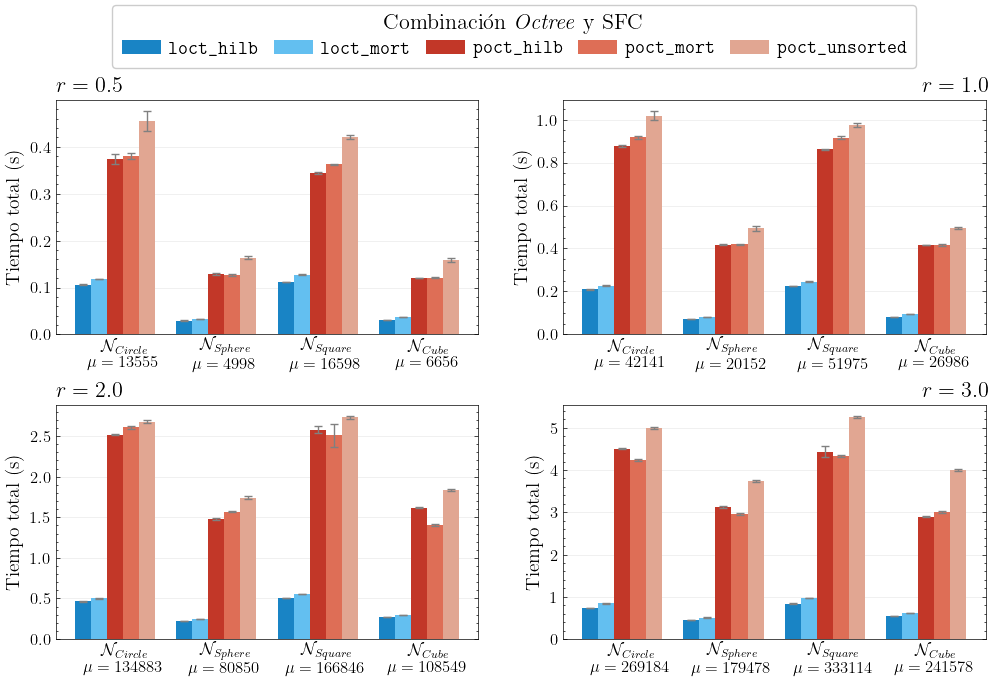

In [350]:
# Paris_Luxembourg_6 SUBSETS
fig = octree_runtime_comparison("Paris_Luxembourg_6", DATA_SUBSET, [NEIGHBORS_PTR, NEIGHBORS_PRUNE], cols=2, figsz=(12,7), legend_pos= (0.85,1.03))
output_fig(fig, "paris_luxembourg_6_subsets")
display(fig)

Loading latest file: out_tfg_v3/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-06-01-10:38:28.csv
                    date        octree point_type           encoder   npoints  \
104  2025-06-01-10:49:35        Octree      Point  HilbertEncoder3D  10000000   
105  2025-06-01-10:49:36        Octree      Point  HilbertEncoder3D  10000000   
106  2025-06-01-10:49:38        Octree      Point  HilbertEncoder3D  10000000   
107  2025-06-01-10:49:39        Octree      Point  HilbertEncoder3D  10000000   
108  2025-06-01-10:49:44        Octree      Point  HilbertEncoder3D  10000000   
..                   ...           ...        ...               ...       ...   
163  2025-06-01-10:54:17  LinearOctree      Point  HilbertEncoder3D  10000000   
164  2025-06-01-10:54:19  LinearOctree      Point  HilbertEncoder3D  10000000   
165  2025-06-01-10:54:20  LinearOctree      Point  HilbertEncoder3D  10000000   
166  2025-06-01-10:54:22  LinearOctree      Point  HilbertEncoder3D  10000000   
167  202

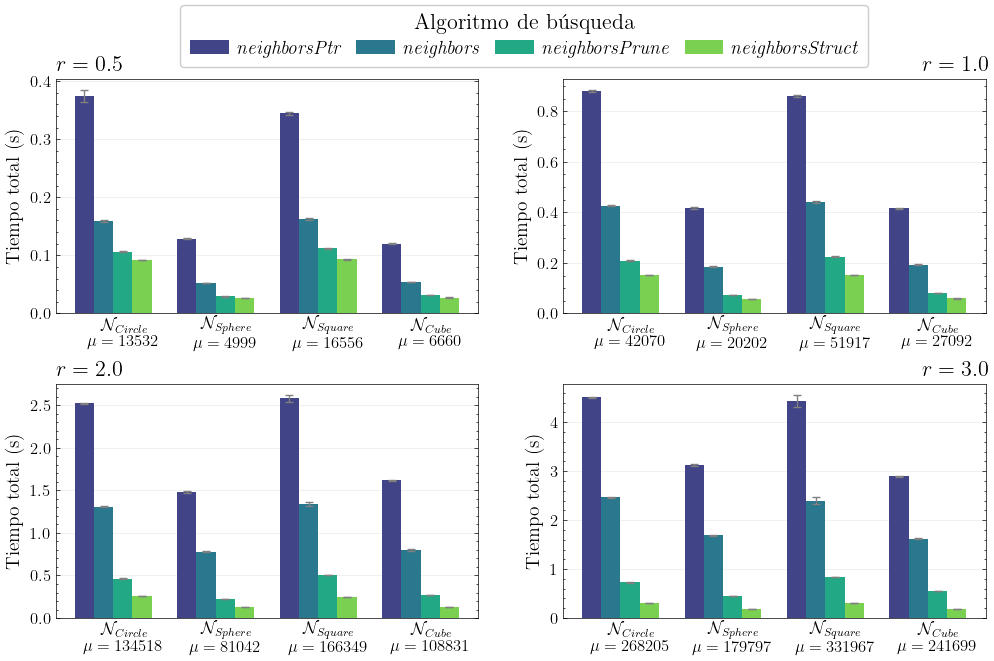

In [351]:
# comparacion algoritmos subset
fig = octree_runtime_comparison("Paris_Luxembourg_6", DATA_SUBSET, [NEIGHBORS_PTR, NEIGHBORS, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT], 
                                    legend_title=r"Algoritmo de búsqueda", cols=2, figsz=(12,7), legend_pos= (0.81,1), types_info=TYPES_INFO_OPERATIONS, encoder=HILBERT_ENCODER)
output_fig(fig, "paris_luxembourg_6_algo_comp_hilb_subsets")
display(fig)

Loading latest file: out_tfg_v3/subset/Lille_0/Lille_0-2025-06-01-10:30:28.csv
Loading latest file: out_tfg_v3/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-06-01-10:38:28.csv
Loading latest file: out_tfg_v3/subset/5080_54400/5080_54400-2025-06-01-10:37:30.csv
Loading latest file: out_tfg_v3/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-06-01-10:55:38.csv
Loading latest file: out_tfg_v3/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-06-01-11:00:41.csv
Loading latest file: out_tfg_v3/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-06-01-12:43:03.csv
Average Morton runtime:  0.8940
Average Hilbert runtime: 0.9650


/tmp/ipykernel_3071/1733707133.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_3071/1733707133.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


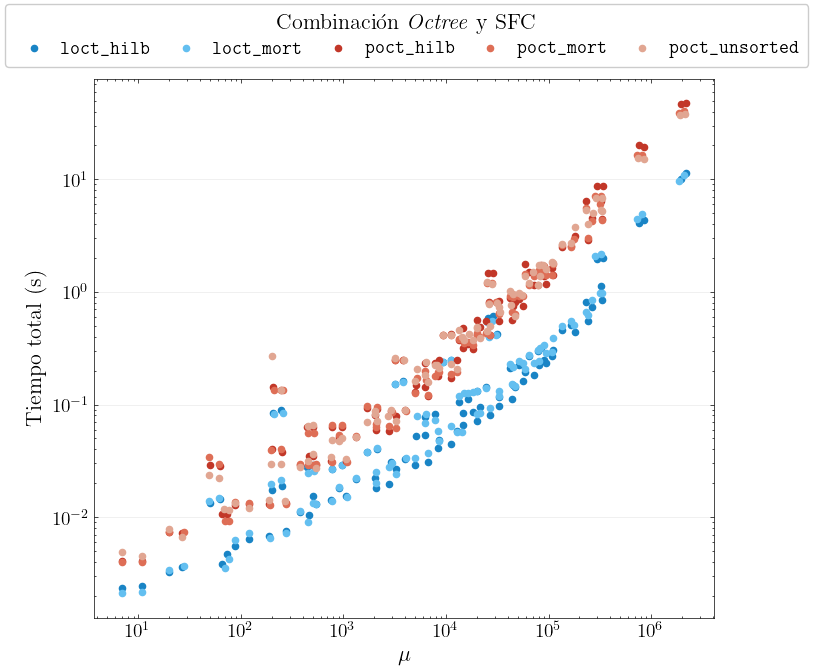

In [352]:
# log-log SUBSETS
fig = plot_avg_result_sizes_log(ALL_CLOUDS, "all", [NEIGHBORS_PTR, NEIGHBORS_PRUNE], DATA_SUBSET, legend_pos= (1.03,1))
output_fig(fig, "loglog_subsets")
display(fig)

Loading latest file: out_tfg_v3/subset/Lille_0/Lille_0-2025-06-01-10:30:28.csv
Loading latest file: out_tfg_v3/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-06-01-10:38:28.csv
Loading latest file: out_tfg_v3/subset/5080_54400/5080_54400-2025-06-01-10:37:30.csv
Loading latest file: out_tfg_v3/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-06-01-10:55:38.csv
Loading latest file: out_tfg_v3/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-06-01-11:00:41.csv
Loading latest file: out_tfg_v3/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-06-01-12:43:03.csv
Average Morton runtime:  0.8940
Average Hilbert runtime: 0.9650


/tmp/ipykernel_3071/1733707133.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_3071/1733707133.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


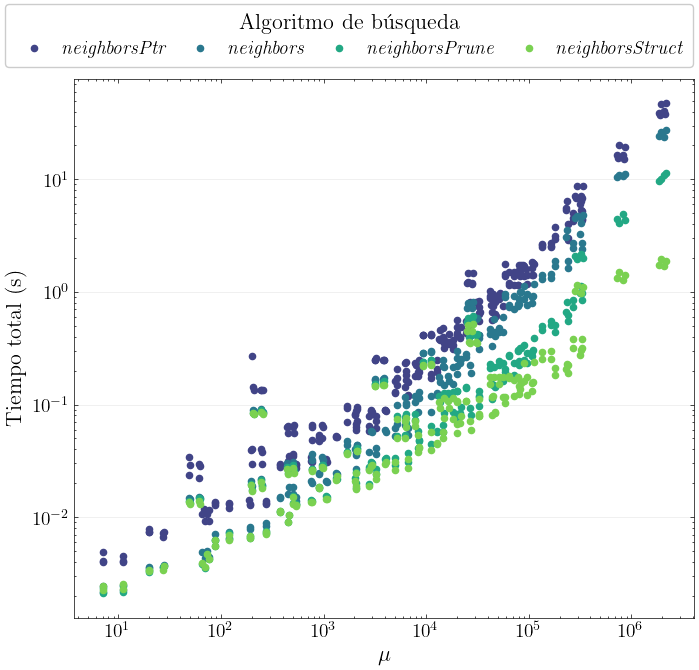

In [353]:
# log-log SUBSETS
fig = plot_avg_result_sizes_log(ALL_CLOUDS, "all", [NEIGHBORS_PTR, NEIGHBORS, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT], DATA_SUBSET, types_info=TYPES_INFO_OPERATIONS, legend_pos= (0.91,1),legend_title=r"Algoritmo de búsqueda")
output_fig(fig, "loglog_subsets_algos")
display(fig)

Loading latest file: out_tfg_v3/subset/Lille_0/Lille_0-2025-06-01-10:30:28.csv
Loading latest file: out_tfg_v3/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-06-01-10:38:28.csv
Loading latest file: out_tfg_v3/subset/5080_54400/5080_54400-2025-06-01-10:37:30.csv
Loading latest file: out_tfg_v3/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-06-01-10:55:38.csv
Loading latest file: out_tfg_v3/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-06-01-11:00:41.csv
Loading latest file: out_tfg_v3/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-06-01-12:43:03.csv
Average Morton runtime:  0.8940
Average Hilbert runtime: 0.9650


/tmp/ipykernel_3071/1733707133.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_3071/1733707133.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


Loading latest file: out_tfg_v3/subset/Lille_0/Lille_0-2025-06-01-10:30:28.csv
Loading latest file: out_tfg_v3/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-06-01-10:38:28.csv
Loading latest file: out_tfg_v3/subset/5080_54400/5080_54400-2025-06-01-10:37:30.csv
Loading latest file: out_tfg_v3/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-06-01-10:55:38.csv
Loading latest file: out_tfg_v3/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-06-01-11:00:41.csv
Loading latest file: out_tfg_v3/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-06-01-12:43:03.csv
Average Morton runtime:  0.8940
Average Hilbert runtime: 0.9650


/tmp/ipykernel_3071/1733707133.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_3071/1733707133.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


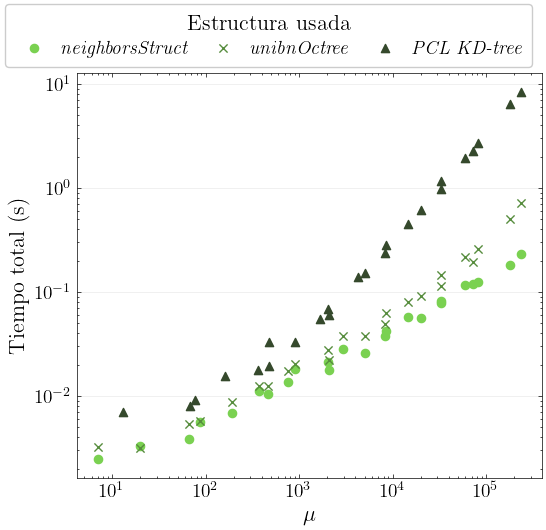

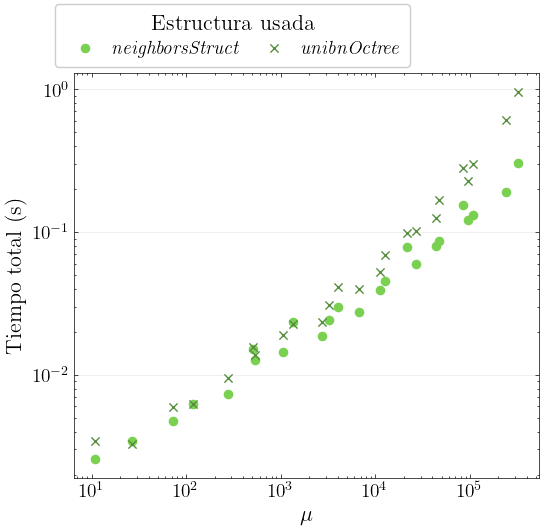

In [354]:
fig = plot_avg_result_sizes_log(ALL_CLOUDS, "Sphere", 
                                [NEIGHBORS_PCLKD, NEIGHBORS_UNIBN, NEIGHBORS_STRUCT], 
                                DATA_SUBSET, encoder=HILBERT_ENCODER, types_info=TYPES_INFO_STRUCTURES, legend_pos=(0.90, 1.03), legend_title=r"Estructura usada", fsz=(4*1.5,3.5*1.5))
output_fig(fig, "loglog_subsets_structures_sphere")

fig2 = plot_avg_result_sizes_log(ALL_CLOUDS, "Cube", 
                                [NEIGHBORS_PCLKD, NEIGHBORS_UNIBN, NEIGHBORS_STRUCT], 
                                DATA_SUBSET, encoder=HILBERT_ENCODER, types_info=TYPES_INFO_STRUCTURES, legend_pos=(0.7, 1.03), legend_title=r"Estructura usada", fsz=(4*1.5,3.5*1.5))
output_fig(fig2, "loglog_subsets_structures_cube")
display(fig)
display(fig2)

In [355]:
def octree_parallelization(cloud, encoder, kernel, octree, data_path, annotated=False):
    df = get_dataset_file(cloud, "latest", data_path)
    df = df[(df["octree"] == octree) & (df["encoder"] == encoder) & (df['kernel'] == kernel)][["num_searches", "repeats", "npoints", "radius", "mean", "openmp_threads"]]
    # Extract ntreads=1 baseline
    baseline = df[df["openmp_threads"] == 1].set_index("radius")["mean"]
    # Merge it on the df
    df = df.merge(baseline.rename("T1"), on="radius")
    # Compute the efficiency as (time 1 thread) / (time n threads * n)
    df["efficiency"] = df["T1"] / (df["openmp_threads"] * df["mean"])
    # Pivot and get the efficiency matrix
    efficiency_matrix = df.pivot(index="radius", columns="openmp_threads", values="efficiency")
    figsize = (7, 2.5)
    fig, ax = plt.subplots(figsize=figsize, gridspec_kw={'top': 0.75})
    heatmap = sns.heatmap(efficiency_matrix, cmap="viridis", annot=annotated, fmt=".2f", linewidths=0, 
                vmin=0, vmax=1, 
                cbar_kws={'label': 'Eficiencia'}, # Add the shrink parameter
                annot_kws={"size": 10},
                ax=ax)    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_ylabel('Eficiencia', fontsize=15)
    plt.subplots_adjust(bottom=0.05)
    # Labels and title
    ax.set_xlabel("Número de hilos", fontsize=15)
    ax.set_ylabel("Radio de búsqueda", fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.tick_params(axis="both", which="both", length=0)
    cbar.ax.tick_params(axis="y", which="both", length=0)
    return fig

Loading latest file: out_tfg_v3/parallel_subset/Lille_0/Lille_0-2025-06-01-16:07:56.csv


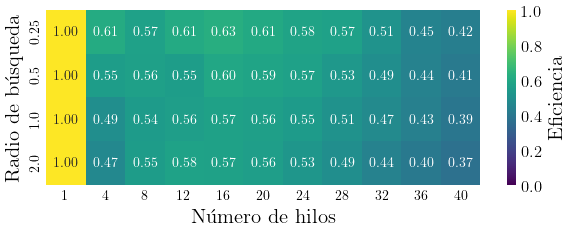

Loading latest file: out_tfg_v3/parallel_subset/Lille_0/Lille_0-2025-06-01-16:07:56.csv


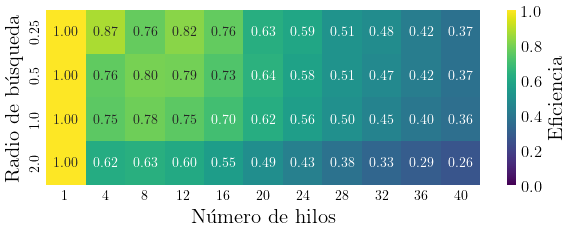

Loading latest file: out_tfg_v3/parallel_subset/Lille_0/Lille_0-2025-06-01-16:07:56.csv


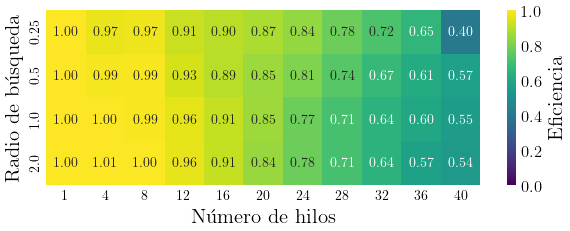

In [356]:
# parallel SUBSETS
fig = octree_parallelization("Lille_0", "NoEncoding", "Sphere", "Octree", DATA_PARALLEL_SUBSET, True)
output_fig(fig, "lille_0_parallel_subset_poct_unsorted")
display(fig)

fig = octree_parallelization("Lille_0", "HilbertEncoder3D", "Sphere", "Octree", DATA_PARALLEL_SUBSET, True)
output_fig(fig, "lille_0_parallel_subset_poct_hilb")
display(fig)

fig = octree_parallelization("Lille_0", "HilbertEncoder3D", "Sphere", "LinearOctree", DATA_PARALLEL_SUBSET, True)
output_fig(fig, "lille_0_parallel_subset_loct_hilb")
display(fig)

Loading latest file: out_tfg_v3/parallel_full/Lille_0/Lille_0-2025-05-29-08:07:16.csv


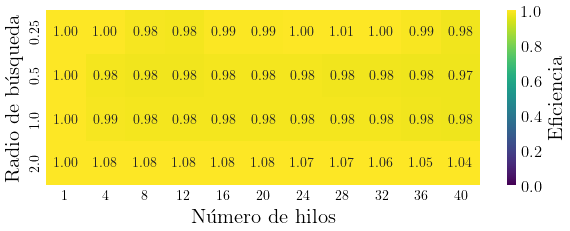

Loading latest file: out_tfg_v3/parallel_full/Lille_0/Lille_0-2025-05-29-08:07:16.csv


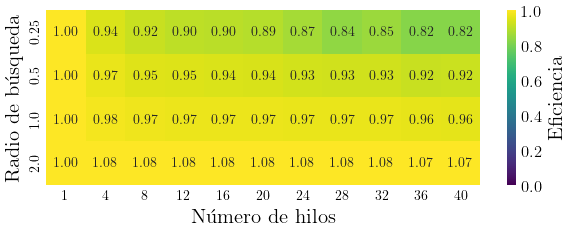

Loading latest file: out_tfg_v3/parallel_full/Lille_0/Lille_0-2025-05-29-08:07:16.csv


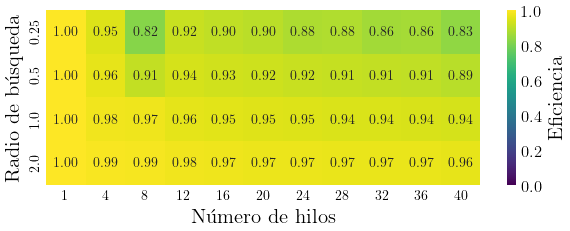

In [357]:
# parallel FULL
fig = octree_parallelization("Lille_0", "NoEncoding", "Sphere", "Octree", DATA_PARALLEL_FULL, True)
output_fig(fig, "lille_0_parallel_full_poct_unsorted")
display(fig)

fig = octree_parallelization("Lille_0", "HilbertEncoder3D", "Sphere", "Octree", DATA_PARALLEL_FULL, True)
output_fig(fig, "lille_0_parallel_full_poct_hilb")
display(fig)

fig = octree_parallelization("Lille_0", "HilbertEncoder3D", "Sphere", "LinearOctree", DATA_PARALLEL_FULL, True)
output_fig(fig, "lille_0_parallel_full_loct_hilb")
display(fig)

### PLOTS QUE NO ESTÁN EN EL PAPER PERO SI EN EL TFG

In [358]:
from matplotlib.ticker import FuncFormatter
def approximate_search_comparison(cloud, dataset, kernel, data_path, encoder = HILBERT_ENCODER, legendpos=(0.85, 1.07)):
    df = get_dataset_file(cloud, "latest", data_path)

    operations = [NEIGHBORS_APPROX_LOWER, NEIGHBORS_STRUCT, NEIGHBORS_APPROX_UPPER]
    operations_palette = {
        NEIGHBORS_STRUCT: "#3ca370",
        NEIGHBORS_APPROX_UPPER: '#1984c5',
        NEIGHBORS_APPROX_LOWER: '#e14b31'
    }
    operations_display_name = {
        NEIGHBORS_STRUCT: 'Exacta',
        NEIGHBORS_APPROX_UPPER: 'Aproximada (Cota Superior)',
        NEIGHBORS_APPROX_LOWER: 'Aproximada (Cota Inferior)'
    }
    df = df[df['operation'].isin(operations)]
    df = df[df['kernel'] == kernel]
    df = df[df['encoder'] == encoder] 
    radii = sorted(df['radius'].unique())
    fig, axes = plt.subplots(len(radii), 1, figsize=(10, 6), gridspec_kw={'hspace': 0.5})
    if len(radii) == 1:
        axes = [axes]

    legend_handles, legend_labels = [], []

    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = df[df['radius'] == radius].copy()
        baseline_row = radius_data[
            (radius_data['operation'] == NEIGHBORS_STRUCT) &
            (radius_data['tolerance_percentage'] == 0)
        ]
        if baseline_row.empty:
            ax.text(0.5, 0.5, f'No exact search data for r = {radius}',
                    transform=ax.transAxes, ha='center', va='center', fontsize=10)
            continue

        baseline = baseline_row['avg_result_size'].iloc[0]
        radius_data['relative_points'] = (radius_data['avg_result_size'] / baseline) * 100

        for op in operations:
            op_data = radius_data[radius_data['operation'] == op].sort_values('relative_points')
            min_x = 1e9
            max_x = -1e9
            if not op_data.empty:
                ax.plot(op_data['relative_points'], op_data['mean'],
                        color='gray', alpha=0.4, linestyle='-')
                scatter = ax.scatter(op_data['relative_points'], op_data['mean'],
                                     color=operations_palette[op], s=70)

                for _, row in op_data.iterrows():
                    xy_test = (10,0) if op == NEIGHBORS_APPROX_UPPER else (-55, 0) if op == NEIGHBORS_APPROX_LOWER else (-20, -15)
                    if row["tolerance_percentage"] == 75:
                        xy_test = (xy_test[0], xy_test[1] - 12)
                    ax.annotate(f"$tol = {row['tolerance_percentage']}\%$",
                                (row['relative_points'], row['mean']),
                                textcoords="offset points", xytext=xy_test,
                                fontsize=12, color='black')

                if radius_idx == 0 and operations_display_name[op] not in legend_labels:
                    legend_handles.append(scatter)
                    legend_labels.append(operations_display_name[op])
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}\%'))
        print(min_x, max_x)
        ax.set_title(f"$r = {radius}$", loc='left')
        ax.set_xlabel("Porcentaje de puntos encontrados")
        ax.set_ylabel(f"Tiempo {'(ms)' if TIMES_IN_MS else '(s)'}")
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')

    add_octree_types_legend(legend_handles, legend_labels, "Método de búsqueda", fig, pos = legendpos)
    return fig


Loading latest file: out_tfg_v3/approx_full/Lille_0/Lille_0-2025-05-29-07:57:47.csv
1000000000.0 -1000000000.0


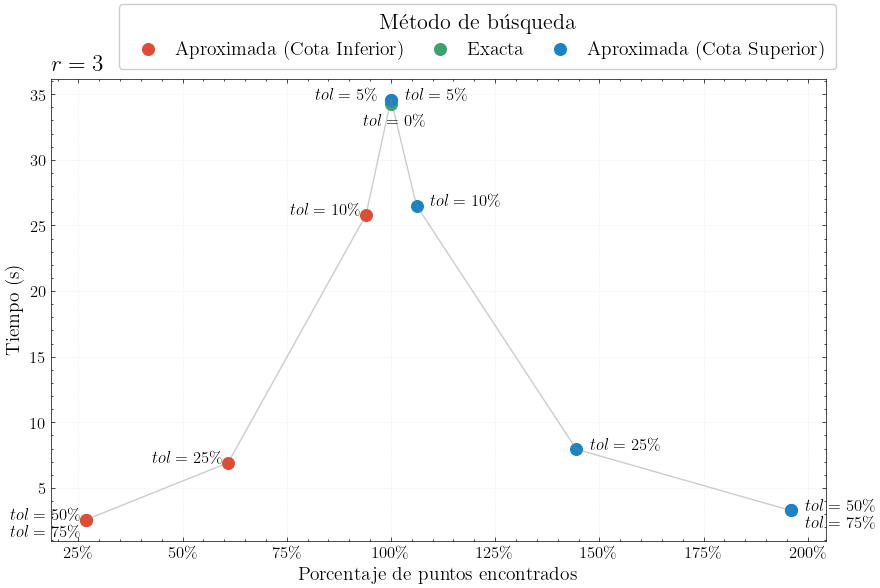

In [359]:
fig = approximate_search_comparison("Lille_0", "Paris_Lille", "Sphere", DATA_APPROX_FULL, legendpos = (0.92, 1.02))
output_fig(fig, "lille_0_approx_subset_sphere_hilbert")
display(fig)

In [360]:
# time to check the build times
PATH_BUILD_128 = os.path.join(BASE_DATA_PATH, "build_128")
dfs = {}
clouds = ["5080_54400", "bildstein_station1_xyz_intensity_rgb", "Lille_0", "Paris_Luxembourg_6", "sg27_station8_intensity_rgb", "Speulderbos_2017_TLS"]
# Load and tag each DataFrame
dfs = []
for cloud in clouds:
    filepath = os.path.join(PATH_BUILD_128, cloud, "enc_octree_times.csv")
    df = pd.read_csv(filepath)
    df["cloud"] = cloud
    dfs.append(df)

df_merged = pd.concat(dfs, ignore_index=True)

In [361]:
# Create a new column for the ratio
df_merged["mu"] =  (df_merged["number_of_nodes"] / df_merged["cloud_size"])
# Group by octree type and compute the average ratio
avg_ratios = df_merged.groupby("oct_type")["mu"].mean()
print(avg_ratios)

oct_type
LinearOctree    0.045420
Octree          0.045417
unibnOctree     0.029800
Name: mu, dtype: float64
